# MNIST

MNISTは手書き数字画像60,000枚と、テスト画像10,000枚を集めた、画像データセット。
各画像に正解ラベルがついており、手書き文字の画像から、書かれた数字を当てるのが目的である。

いわゆる多クラス分類の問題である

### インポートとデータ読み込み


各画像は28画素x28画素(784ピクセル)の白黒画像となっている。

以下ではランダムに選んだ81画像を表示させている。

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)
Tensorflow version 2.2.0-rc2


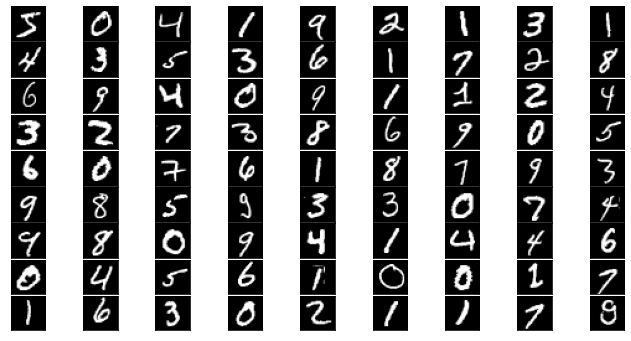

In [0]:
# tensorflow 2.x には keras>=2.3.x が必要
!pip install -U keras

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

print("Tensorflow version " + tf.__version__)

#Kerasの関数でデータの読み込み。データをシャッフルして学習データと訓練データに分割
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#MNISTデータの表示
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)
for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i].reshape((28, 28)), cmap='gray')

### データ加工
- 28x28の２次元データを、1次元の大きさ784の数値列に変換する

### ※工夫のポイント
- データの中身は、扱うものによって、さまざまな値をとる（例：テストの点数(0-100)、気温、株価、緯度経度、金額）
- このうち、複数のデータ値を一緒に学習することを考える
  - 例：ニューヨークの気温とNYSEの株価
  - この際に、気温はおおよそ20-30の範囲、株価は10000前後、のように桁が違うデータを同時にトレーニングすると精度が落ちる
  - したがって、すべてのデータを同じ範囲に揃える（たとえば0.0～1.0の間）これを **正規化** と呼ぶ

### 正規化

一般的には、配列 x があったとき、以下のような式で、値を `0.0 - 1.0` に収めることができる

```python
def normalize(x):
    max_x = np.max(x, axis=(0, 1), keepdims=True)
    min_x = np.min(x, axis=(0, 1), keepdims=True)
    return (x - min_x) / (max_x - min_x)
```

画像データの場合、データの値は `0 - 255` の値を取るので、上の式に当てはめると、
`min_x` が 0 となり、もとのデータの値を `255` で割れば良いことがわかる。

In [0]:
# 2次元データを1次元に変換
# (60000, 28, 28) -> (60000, 784)
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
# 型変換
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# 255で割ったものを新たに変数とする
x_train /= 255
x_test /= 255

### 正解ラベルの加工

- 元のデータセットには4, 7, 9, 0, 1, ...のように数値で入っています (これを名義尺度といいます)。
- 名義尺度の数(ここでは名義尺度は 0-9 なので 10)をクラス数といいます。
- 名義尺度を大きさがクラス数のベクトルに直します (これを One-Hot表現といいます)
-（例：`2` -> `[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]`)
- one-hot表現にする理由は、そのほうが精度が上がるから。(精度が上がる理由は各自調べる）

In [0]:
num_classes = 10
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

# to_categorical: one-hot encodingを施すためのメソッド
y_train = to_categorical(y_train, num_classes)
y_test =  to_categorical(y_test, num_classes)

### ネットワークの構築
- モデルを定義（作成）します


In [0]:
# モデル作成

# Sequential: ネットワークを1列に積み上げているシンプルな方法
model = Sequential()

# 入力層では、入力データの大きさ input_shape を指定する。
# (1次元の場合は (xxx, ) と書かないとタプルではなく数値扱いとなってしまう)

# Dense は入力と出力をすべて接続する 全結合 のレイヤー (ここでは出力次元数が 256)

# 活性化関数(activation) はネットワークに「非線形性」を導入するために必要。 
# 正規化線形関数 relu は精度が良いとされている活性化関数の一つ
model.add(Dense(256, activation='relu', input_shape=(784,)))

# Dropoutは、モデルの「過学習」を防止するためのテクニックの一つ。
# 指定された割合の値を `0` にしてしまうことで、学習を難しくし、過学習を防止する
# 過学習とは、トレーニング用のデータに特化しすぎたモデルとなってしまい、
# テスト用のデータで性能があがらなくなってしまう状態のこと。
# テスト用のデータでの性能を「汎化性能」と言ったりする
model.add(Dropout(0.2))

# Deep Learningは一般的に 3層以上のニューラルネットワークを使用するものをいう。
# ネットワークは層が多ければ、性能は良くなりやすいが、学習時間が伸びてしまい、リソースも多く必要になる。
# 学習時間の短縮と性能の向上をさまざまなアルゴリズムやテクニックで伸ばしていく。

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# 出力層では、クラス数が出力データ数となるようにする。
# 多クラス分類では、出力層の活性化関数に softmax を使うのが一般的
model.add(Dense(num_classes, activation='softmax'))

### モデルサマリの表示

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

## 学習の設定

### 損失関数

- 損失関数(コスト関数) loss は、モデルを学習する際に基準となる関数で、この関数の値が小さくなるようにパラメータを更新していく。
- パラメータを更新するためには、どのようにパラメータを更新すれば、損失関数の値が小さくなるか分かる必要があり、そのために、損失関数は連続で微分可能である必要がある。
- 多クラス分類では、損失関数として categorical_crossentropy がよく使われる(性能がよい)

### 最適化関数

- 最適化関数 optimizer は、パラメータを「どのくらい」更新したらよいかを決める関数。
- Adam はその中でも収束が早い(学習が早い) 最適化関数として知られている

### 学習の指標

ここでは、学習の指標として 正解率 accuracy を使う

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

### 学習とテスト
- バッチサイズとは、一回の計算で同時に処理するデータ数です
- **エポック** とは、トレーニングデータセット（この場合、60000データ）をいったん全部学習することを指します
  - 通常、エポックを複数回繰り返すことで、誤差が徐々に小さくなるため、60000データの学習を何セットも繰り返す、ということを行います

### 学習の途中経過の表示
- １エポック終了ごとに、そこまでの経過を表示します
  - loss: トレーニングデータでの誤差の大きさ（小さいほど良い）
  - acc: トレーニングデータでの精度（大きいほど良い。1.0=100%)
- エポック終了ごとにテストデータでも精度をみます。
  - val_loss: テストデータでの誤差の大きさ（小さいほど良い）
  - val_acc: テストデータでの精度（大きいほど良い。1.0=100%)

In [0]:
# バッチサイズ、エポック数
batch_size = 128
epochs = 20

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 64us/step - loss: 0.3497 - accuracy: 0.8917 - val_loss: 0.1265 - val_accuracy: 0.9606
Epoch 2/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.1428 - accuracy: 0.9591 - val_loss: 0.0975 - val_accuracy: 0.9690
Epoch 3/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.1068 - accuracy: 0.9684 - val_loss: 0.0905 - val_accuracy: 0.9731
Epoch 4/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.0873 - accuracy: 0.9740 - val_loss: 0.0757 - val_accuracy: 0.9794
Epoch 5/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.0744 - accuracy: 0.9775 - val_loss: 0.0752 - val_accuracy: 0.9784
Epoch 6/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.0685 - accuracy: 0.9786 - val_loss: 0.0698 - val_accuracy: 0.9805
Epoch 7/20
60000/60000 [==============================] - 2s 33us/st

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06843761885338036
Test accuracy: 0.9818999767303467


### 精度と損失関数のグラフ化
- 可視化は大事

### 見るべきポイント
- loss/accともに、トレーニングデータだけ最適化されてテストデータの精度（損失）が著しく悪ければ、それは「過学習」のあらわれ
- 言い換えると、トレーニングデータの精度だけあがっても、テストデータやその他の現実のデータで精度が高くないと現実的に使えるAIにならない


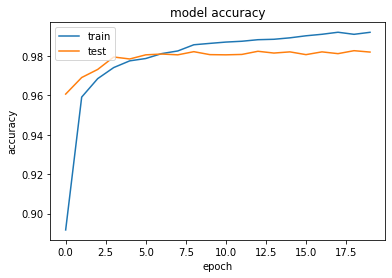

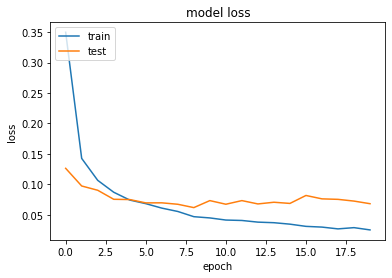

In [0]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## その他の指標

正解率以外にも、指標とすべき値はいくつかある。混同行列などで、調べてみると良い